# CMA/ES PER SUBJECT - 5 try: GORGO11 - EM fits Scaled

Latest for thesis

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import io
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sys
from IPython.utils import io

from experimentlauncher import ExperimentLauncher
from dataio import DataIO
import plots_experimental_data
import em_circularmixture_parametrickappa

import progress

# import matplotlib.animation as plt_anim
from mpl_toolkits.mplot3d import Axes3D

import glob
import re
import inspect
import imp

import utils
# import submitpbs
import load_experimental_data

from plots_fitexperiment_papertheo import PlotsFitExperimentAllTPaperTheo

oldstdout = None

## Reload data

In [3]:
%cd /nfs/data3/lmatthey/visual_working_mem/fitexperiment_subject_cmaes_08_2016/5try_g11_emfit/

metric = 'dist_emfit_scaled'
folder_pattern = "cmaes_subjects_gorgo11_emfitscaled_5try_Mratiosigmaxsigmabaselinelapserate_subject*"
re_subject = re.compile(".*subject([0-9]*)rep")

df_all_fits = None

for filename in glob.glob("./%s/outputs/cmaes_alliter_tracking*.npy" % folder_pattern):
    found = re_subject.match(filename)
    subject = int(found.group(1))
    print "Reloading data of Subject %d" % subject
    
    curr_cmaes_trace = np.load(filename).item()

    candidates_parameters = np.array(curr_cmaes_trace['candidates'])
    fitness = np.array(curr_cmaes_trace['fitness'])
    parameter_names_sorted = curr_cmaes_trace['parameter_names_sorted']
    
    df_fits_subject = pd.DataFrame.from_items([('step', np.arange(fitness.size)), 
                                               ('experiment_subject', subject),
                                               (metric, np.ma.masked_greater(fitness.flatten(), 1e8))] + 
                                               [(param, candidates_parameters[:, param_i]) 
                                                    for param_i, param in enumerate(parameter_names_sorted)])
    
    if df_all_fits is None:
        df_all_fits = df_fits_subject
    else:
        df_all_fits = df_all_fits.append(df_fits_subject, ignore_index=True)
        
df_all_fits = df_all_fits.sort_values(by=['experiment_subject', 'step'])
subject_space = np.sort(df_all_fits['experiment_subject'].unique())

parameter_names_sorted

/nfs/data3/lmatthey/visual_working_mem/fitexperiment_subject_cmaes_08_2016/5try_g11_emfit
Reloading data of Subject 5
Reloading data of Subject 1
Reloading data of Subject 3
Reloading data of Subject 4
Reloading data of Subject 2
Reloading data of Subject 8
Reloading data of Subject 6
Reloading data of Subject 7


['M', 'lapse_rate', 'ratio_conj', 'sigma_baseline', 'sigmax']

In [4]:
# Fix M and ratio_conj
M_corrected, ratio_corrected = utils.fix_M_ratioconj(df_all_fits['M'], df_all_fits['ratio_conj'])
df_all_fits.loc[:, 'M'] = M_corrected
df_all_fits.loc[:, 'ratio_conj'] = ratio_corrected

In [5]:
df_all_fits.loc[:, metric + "_log"] = np.log(df_all_fits[metric])
df_all_fits.loc[:, metric + "_log10"] = np.log10(df_all_fits[metric])

In [6]:
# Filter rows where LL > cutoff value and remove lapse_rate > cutoff
LL_max_cutoff = 2000
df_best_fits = df_all_fits[df_all_fits[metric] < LL_max_cutoff]

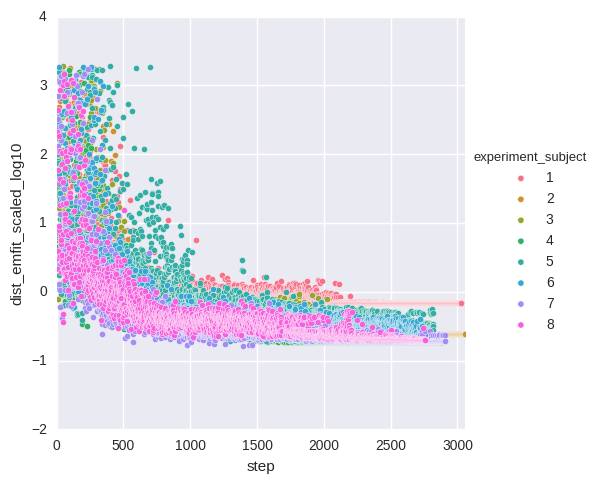

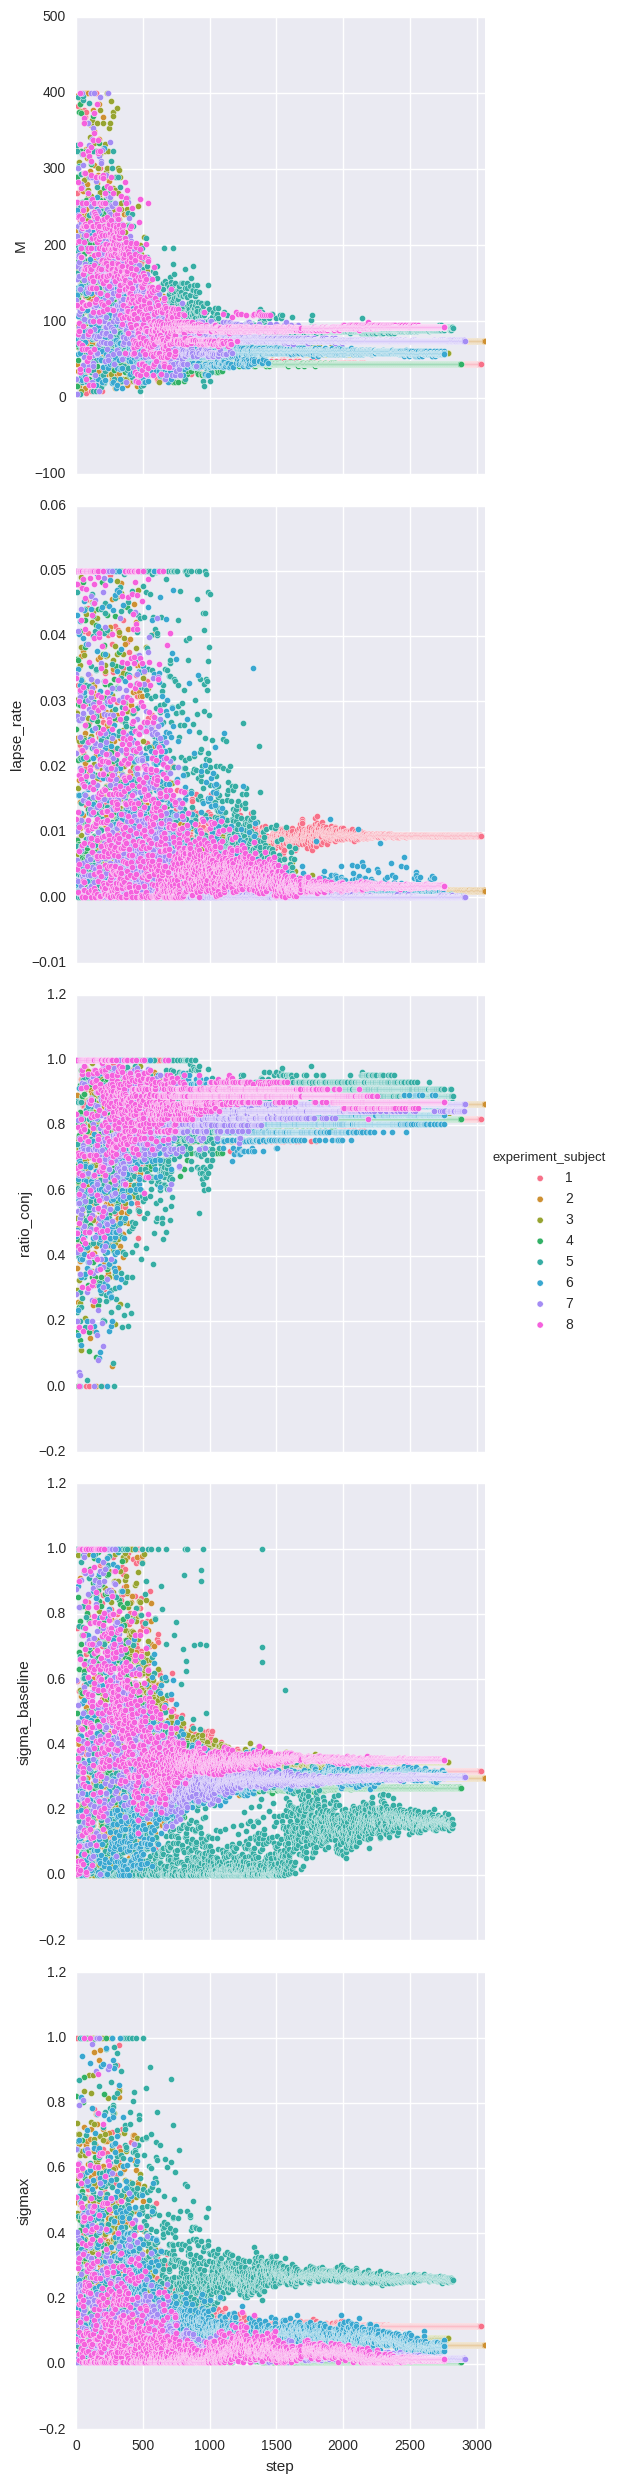

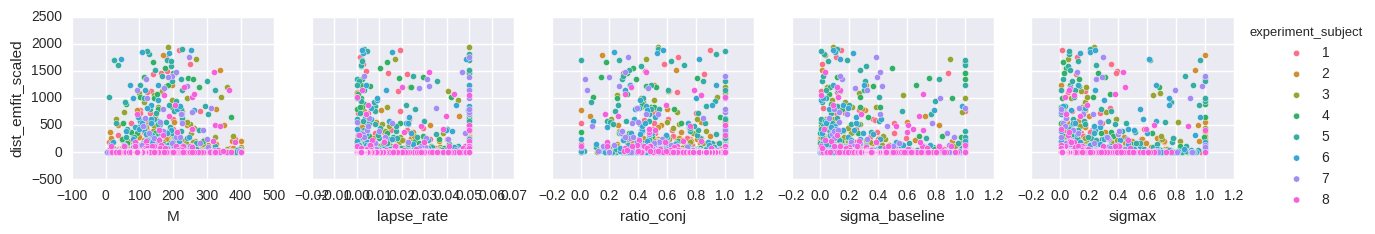

In [7]:
# Learning curve
g = sns.pairplot(df_best_fits,
                 y_vars=[metric + "_log10"],
                 x_vars=['step'],
                 hue='experiment_subject',
                 size=5,
                )

g.set(xlim=(-1, df_best_fits['step'].max())
)

# Check training of parameters
g = sns.pairplot(df_best_fits,
                 y_vars=parameter_names_sorted,
                 x_vars=['step'],
                 hue='experiment_subject',
                 size=5
                )
g.set(xlim=(-1, df_best_fits['step'].max()))

# Check parameters effects
sns.pairplot(df_best_fits,
             x_vars=parameter_names_sorted,
             y_vars=[metric],
             hue='experiment_subject',
            )


## Check parameters values obtained

In [8]:
df_bestparams_subjects = df_best_fits.groupby('experiment_subject').apply(
#     lambda subDf: subDf.sort_values('step', ascending=False).head(1).median()
    lambda subDf: subDf.sort_values('dist_emfit_scaled', ascending=True).head(1).median()
)
df_bestparams_subjects

,step,experiment_subject,dist_emfit_scaled,M,lapse_rate,ratio_conj,sigma_baseline,sigmax,dist_emfit_scaled_log,dist_emfit_scaled_log10
experiment_subject,,,,,,,,,,
1,1338.0,1.0,0.634635,46.0,7.892421e-03,0.782609,0.307925,0.128781,-0.454705,-0.197476
2,1323.0,2.0,0.223945,78.0,7.255726e-08,0.820513,0.318183,0.065243,-1.496354,-0.649858
3,2711.0,3.0,0.351692,59.0,3.358373e-04,0.830508,0.347328,0.078542,-1.045001,-0.453838
4,2585.0,4.0,0.184778,44.0,2.433834e-04,0.818182,0.268404,0.005655,-1.688600,-0.733350
5,756.0,5.0,0.234408,72.0,6.825807e-03,0.888889,0.247773,0.118062,-1.450692,-0.630027
6,1781.0,6.0,0.192043,61.0,9.882605e-04,0.803279,0.294159,0.119406,-1.650035,-0.716601
7,1396.0,7.0,0.162301,78.0,5.243390e-04,0.820513,0.296404,0.052687,-1.818300,-0.789678
8,2639.0,8.0,0.199178,93.0,1.801509e-03,0.870968,0.352974,0.014260,-1.613555,-0.700758


In [9]:
params_mean = df_bestparams_subjects.mean()
params_std = df_bestparams_subjects.std()

for param in parameter_names_sorted:
    print("%s   %.3g +- %.3g" % (param, params_mean[param], params_std[param]))

M   66.4 +- 16.9
lapse_rate   0.00233 +- 0.00317
ratio_conj   0.829 +- 0.0347
sigma_baseline   0.304 +- 0.036
sigmax   0.0728 +- 0.0475


In [10]:
best_params_subj = df_bestparams_subjects.sort_values('dist_emfit_scaled')[
    ['experiment_subject'] + parameter_names_sorted + [metric]].reset_index(drop=True)
# print(best_params_subj.to_latex())
best_params_subj

,experiment_subject,M,lapse_rate,ratio_conj,sigma_baseline,sigmax,dist_emfit_scaled
0,7.0,78.0,5.243390e-04,0.820513,0.296404,0.052687,0.162301
1,4.0,44.0,2.433834e-04,0.818182,0.268404,0.005655,0.184778
2,6.0,61.0,9.882605e-04,0.803279,0.294159,0.119406,0.192043
3,8.0,93.0,1.801509e-03,0.870968,0.352974,0.014260,0.199178
4,2.0,78.0,7.255726e-08,0.820513,0.318183,0.065243,0.223945
5,5.0,72.0,6.825807e-03,0.888889,0.247773,0.118062,0.234408
6,3.0,59.0,3.358373e-04,0.830508,0.347328,0.078542,0.351692
7,1.0,46.0,7.892421e-03,0.782609,0.307925,0.128781,0.634635


/nfs/nhome/live/lmatthey/Applications/anaconda/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/nfs/nhome/live/lmatthey/Applications/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


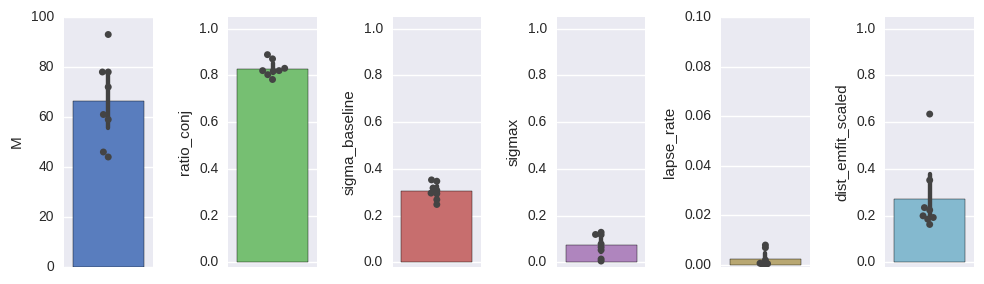

In [11]:
# df_best_params_meld = pd.melt(df_bestparams_subjects, id_vars=['experiment_subject', 'step', 'dist_nll'])
parameter_names_sorted = ['M', 'ratio_conj', 'sigma_baseline', 'sigmax', 'lapse_rate', metric]
colors = sns.color_palette('muted', n_colors=len(parameter_names_sorted))
fig_parameters, axes = plt.subplots(1, len(parameter_names_sorted), figsize=(10, 3))
axes = axes.flatten()
for i, param in enumerate(parameter_names_sorted):
    sns.barplot(df_bestparams_subjects[param], orient='v', ax=axes[i], color=colors[i])
    sns.swarmplot(df_bestparams_subjects[param], orient='v', ax=axes[i], color='#444444')

axes[0].set_ylim((-0.02, 100))
for ax in axes[1:-2]:
    ax.set_ylim((-0.02, 1.05))
axes[-2].set_ylim((-0.001, 0.1))
axes[-1].set_ylim((-0.02, 1.05))
fig_parameters.set_tight_layout(True)


## Get plots for all subjects, and associated EM fits

In [12]:
experiment_parameters = dict(action_to_do='launcher_do_fitexperiment_subject_allmetrics',
                             inference_method='sample',
                             experiment_id='gorgo11',
                             selection_method='last',
                             renormalize_sigma=None,
                             sigmay=0.00001,
                             num_samples=10,
                             code_type='mixed',
                             slice_width=0.07,
                             burn_samples=10,
                             ratio_conj=0.7,
                             stimuli_generation_recall='random',
                             autoset_parameters=None,
                             )

all_results = dict()
all_plots_fit_exp = dict()

for subject in progress.ProgressDisplay(subject_space):
    print "FitExperimentAllTSubject for subject %d" % subject

    experiment_parameters.update(df_bestparams_subjects.loc[subject])
    for key in ['M', 'experiment_subject']:
        experiment_parameters[key] = int(experiment_parameters[key])
    
    with io.capture_output() as captured:
        experiment_launcher = ExperimentLauncher(run=True, arguments_dict=experiment_parameters)
        fit_exp = experiment_launcher.all_vars['fit_exp']
        all_results[subject] = experiment_launcher.all_vars['all_outputs_data']
        all_plots_fit_exp[subject] = PlotsFitExperimentAllTPaperTheo(fit_exp)
        

[0%] --
FitExperimentAllTSubject for subject 1
[12%] 6m14s
FitExperimentAllTSubject for subject 2
[25%] 5m28s
FitExperimentAllTSubject for subject 3
[37%] 4m41s
FitExperimentAllTSubject for subject 4
[50%] 3m42s
FitExperimentAllTSubject for subject 5
[62%] 2m48s
FitExperimentAllTSubject for subject 6
[75%] 1m53s
FitExperimentAllTSubject for subject 7
[87%] 58s
FitExperimentAllTSubject for subject 8
[100%] 7m36s


In [13]:
dist_emfitscaled_subjects = np.array([np.nansum(results['result_emfit_mse_scaled']) 
                                      for sub, results in all_results.iteritems()])
subject_space_sorted_bis = np.argsort(dist_emfitscaled_subjects) + 1

[0%] --
Subject 7
[12%] 6s
Subject 5
[25%] 5s
Subject 2
[37%] 4s
Subject 8
[50%] 3s
Subject 6
[62%] 2s
Subject 4
[75%] 2s
Subject 3
[87%] 1s
Subject 1
[100%] 6s


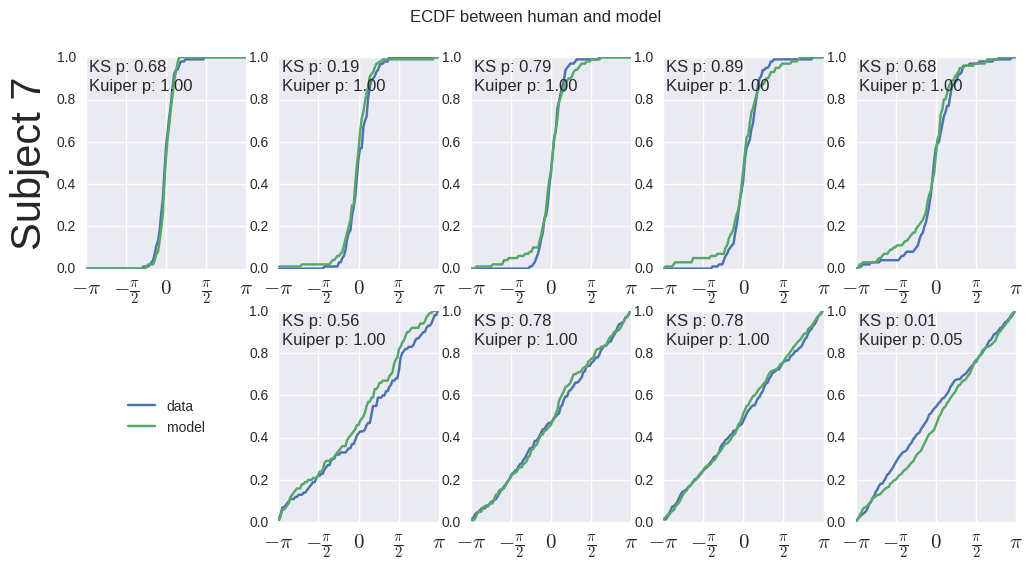

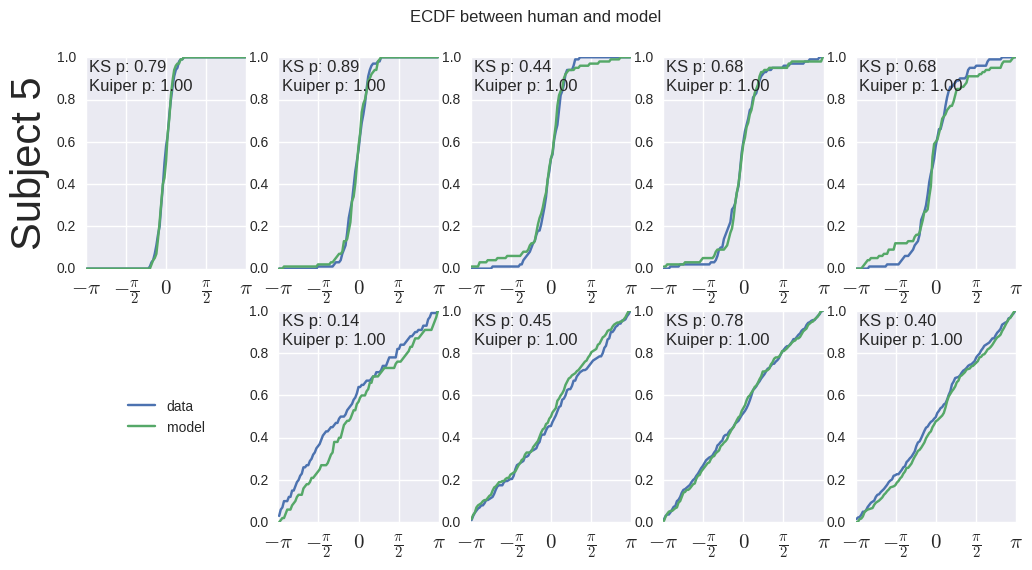

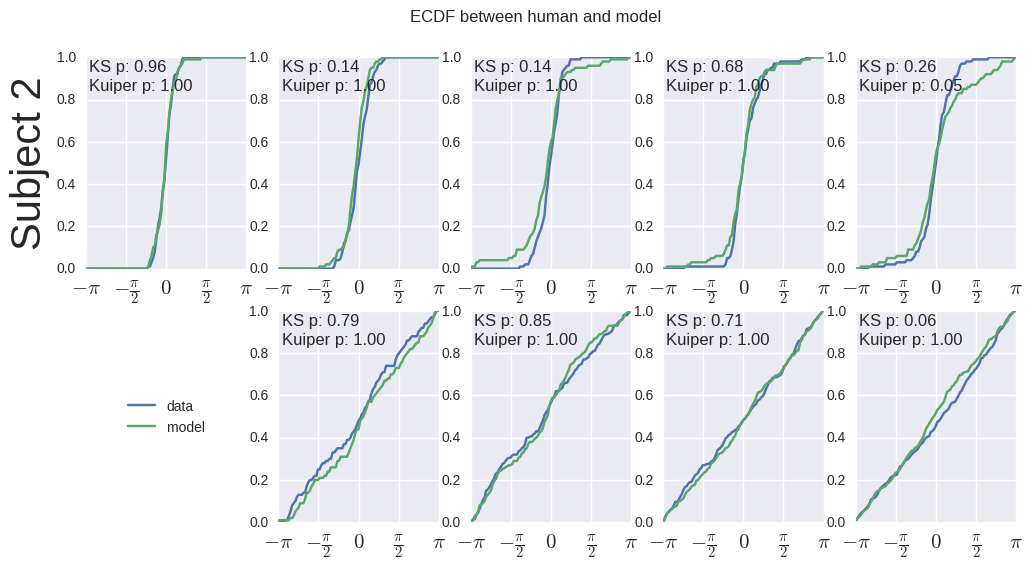

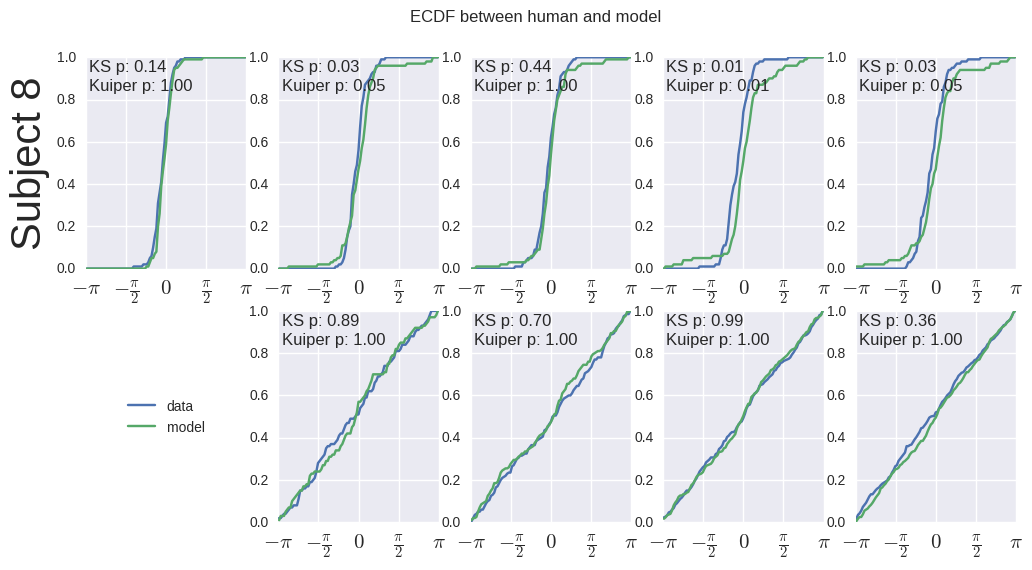

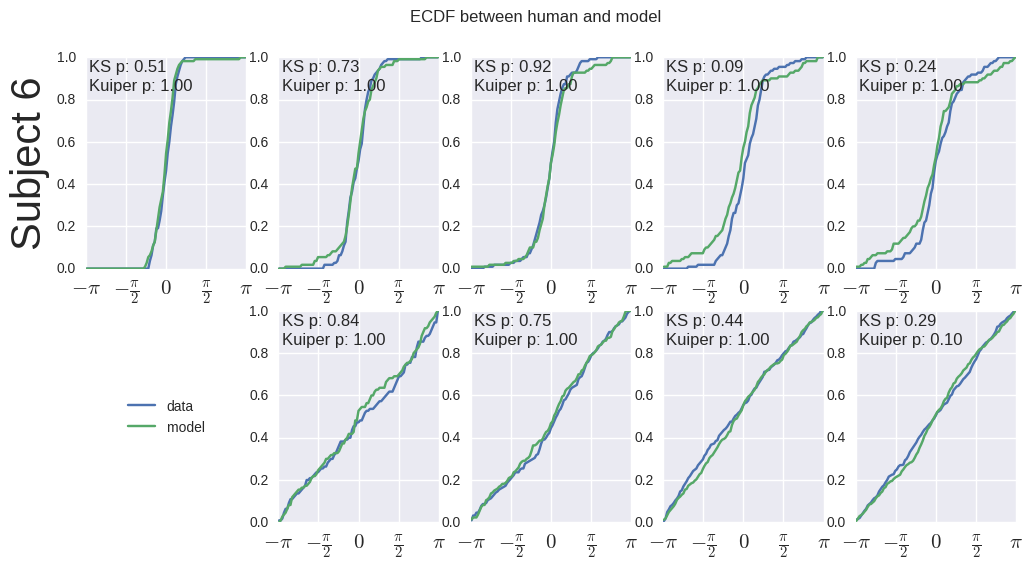

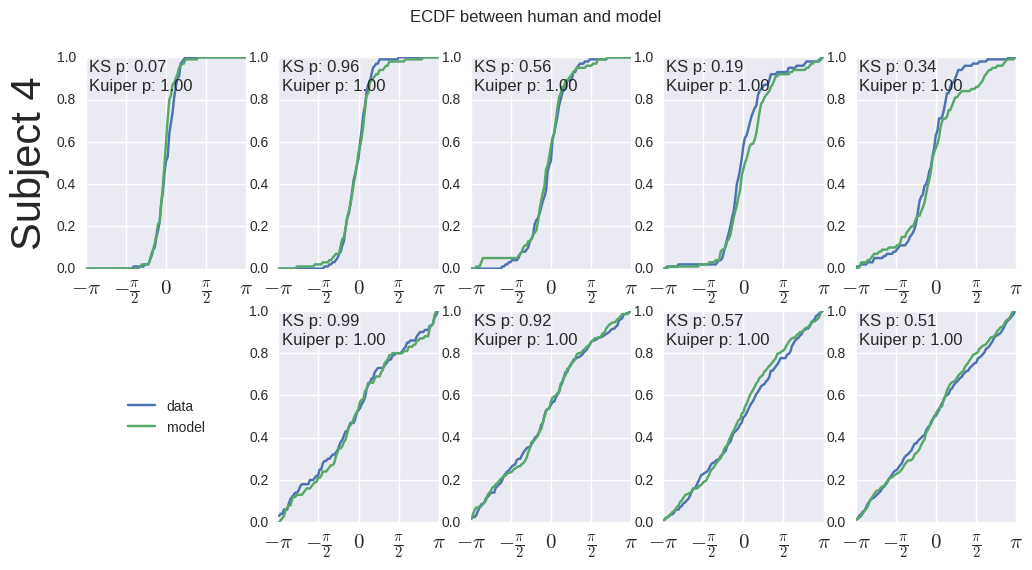

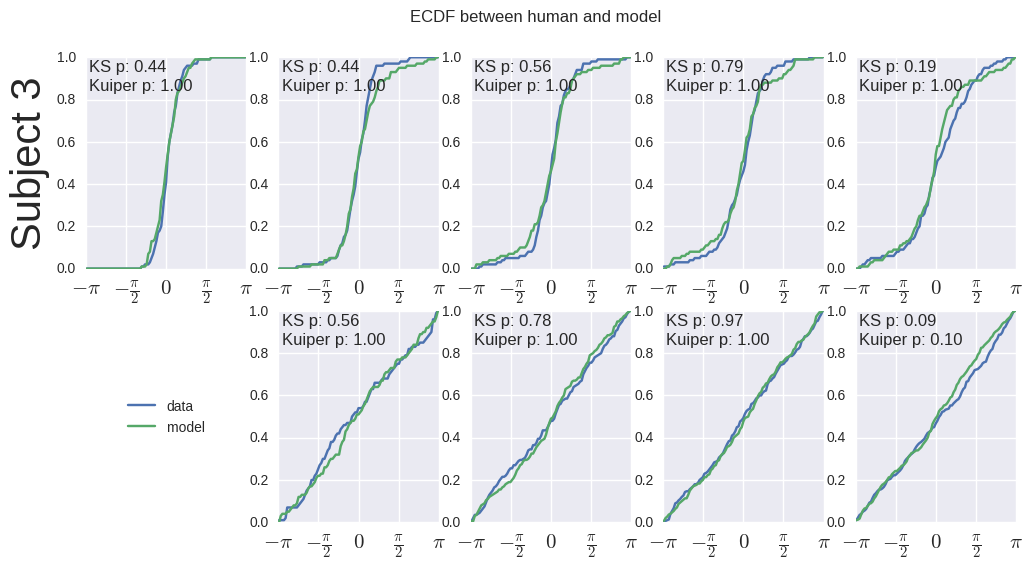

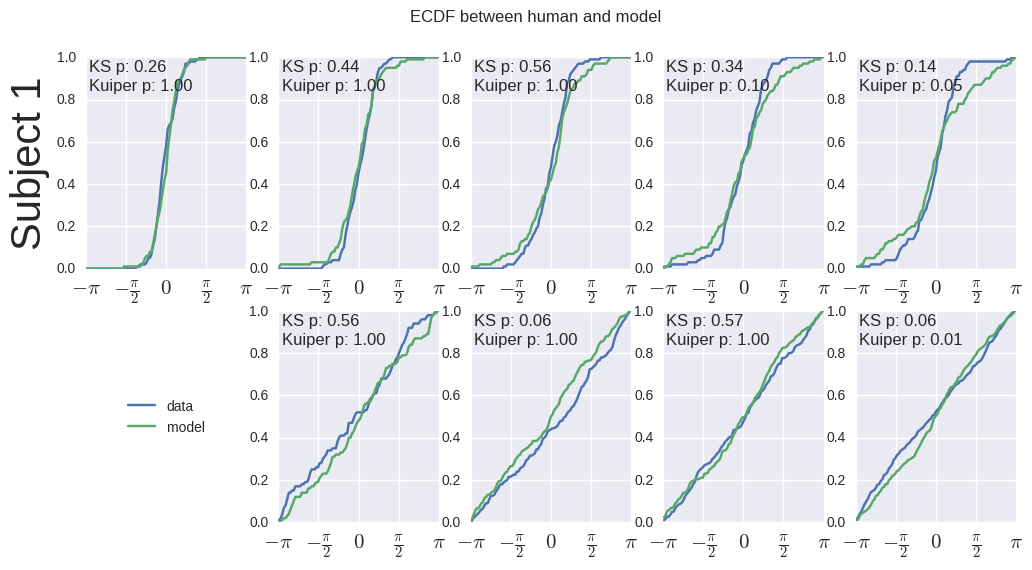

In [14]:
all_histogram_results = dict()
all_axes_cdf = dict()

for subject in progress.ProgressDisplay(subject_space_sorted_bis):
    print "Subject %d" % subject
    with io.capture_output(display=False, stderr=False) as captured:
        all_axes_cdf[subject], all_histogram_results[subject] = all_plots_fit_exp[subject].plots_KS_comparison_fig2fig5(bins=100)
        all_axes_cdf[subject][0, 0].set_ylabel('Subject %d' % subject, fontsize=30)


In [15]:
T_space = np.sort(all_histogram_results[subject]['kuiper_pval'].keys())

str_out = ""
for subject in progress.ProgressDisplay(subject_space_sorted_bis):
    count_significant = 0
    str_out = str_out + "S:%3d | " % subject
    for condition in ['targets', 'nontargets']:
        for T, data in all_histogram_results[subject]['kuiper_pval'].iteritems():
            if condition in data:
                str_out = str_out + "%.3f " % data[condition]
                if data[condition] > 0.05:
                    count_significant += 1
        
        str_out = str_out + " | "
    
    str_out = str_out + " => %d good" % count_significant
    str_out = str_out + '\n'
print str_out

[0%] --
[12%] 0s
[25%] 0s
[37%] 0s
[50%] 0s
[62%] 0s
[75%] 0s
[87%] 0s
[100%] 0s
S:  7 | 1.000 1.000 1.000 1.000 1.000  | 1.000 1.000 1.000 0.050  |  => 8 good
S:  5 | 1.000 1.000 1.000 1.000 1.000  | 1.000 1.000 1.000 1.000  |  => 9 good
S:  2 | 1.000 1.000 1.000 1.000 0.050  | 1.000 1.000 1.000 1.000  |  => 8 good
S:  8 | 1.000 0.050 1.000 0.010 0.050  | 1.000 1.000 1.000 1.000  |  => 6 good
S:  6 | 1.000 1.000 1.000 1.000 1.000  | 1.000 1.000 1.000 0.100  |  => 9 good
S:  4 | 1.000 1.000 1.000 1.000 1.000  | 1.000 1.000 1.000 1.000  |  => 9 good
S:  3 | 1.000 1.000 1.000 1.000 1.000  | 1.000 1.000 1.000 0.100  |  => 9 good
S:  1 | 1.000 1.000 1.000 0.100 0.050  | 1.000 1.000 1.000 0.005  |  => 7 good



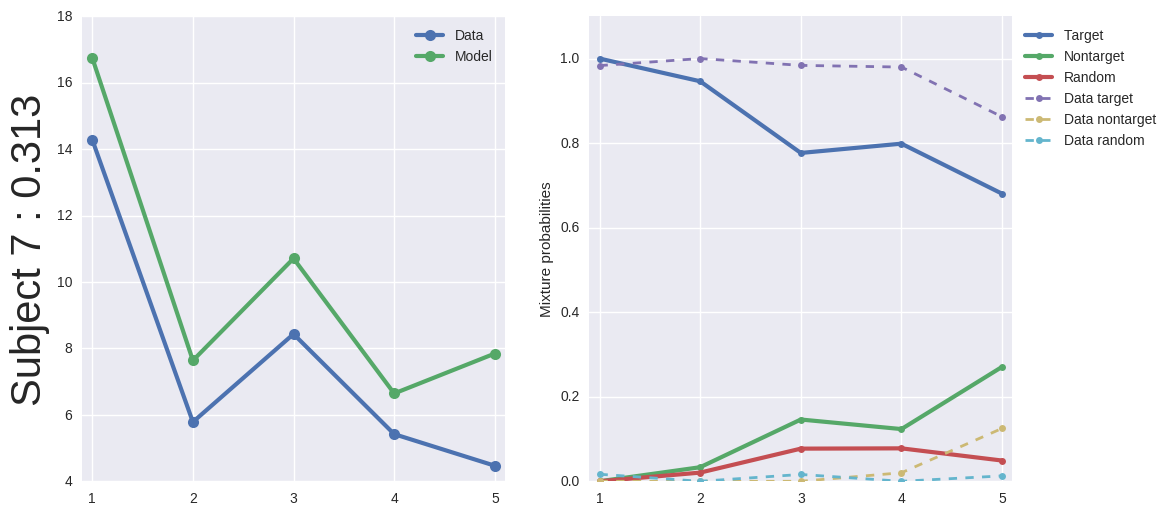

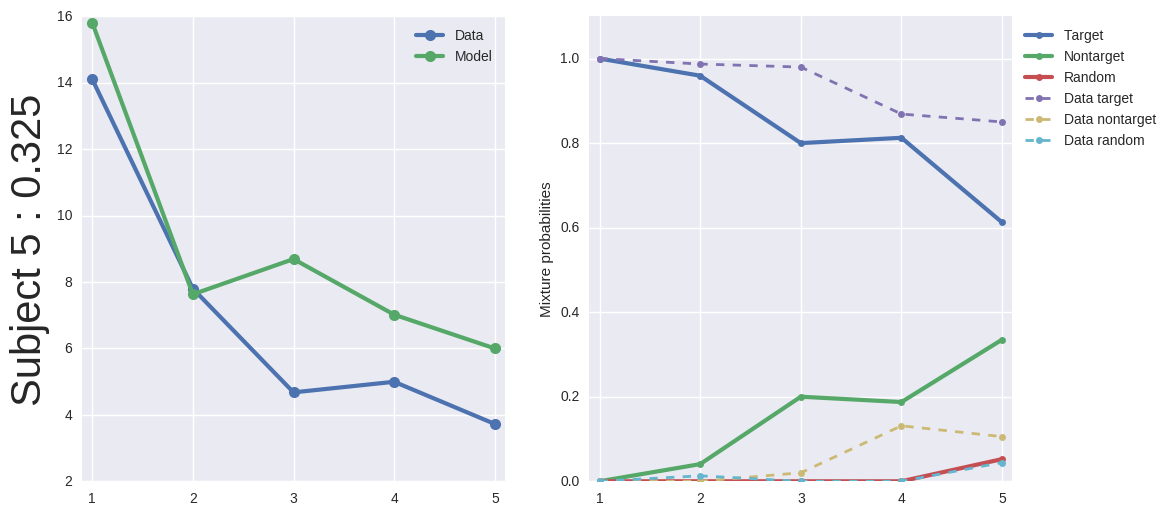

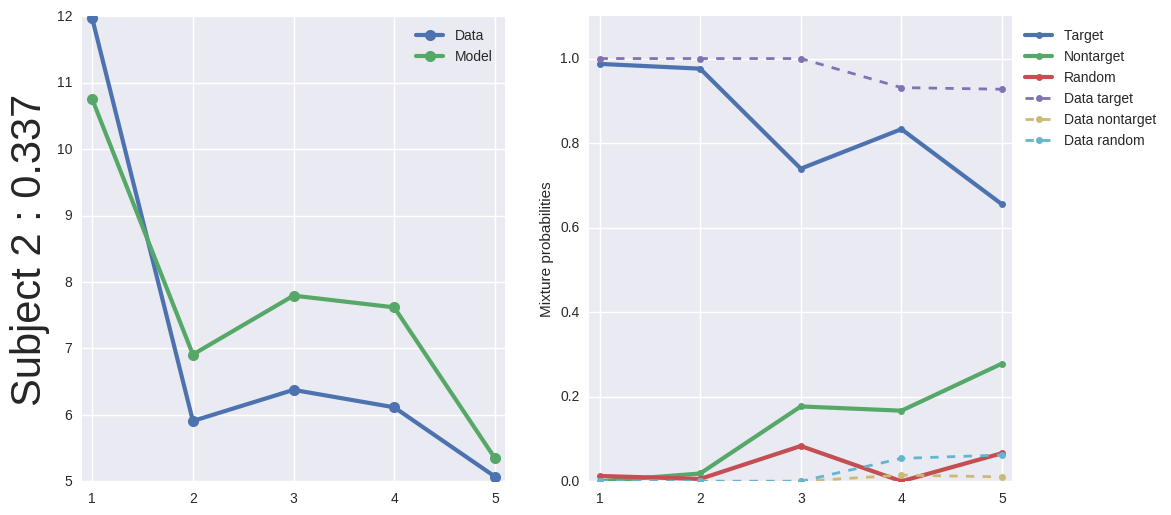

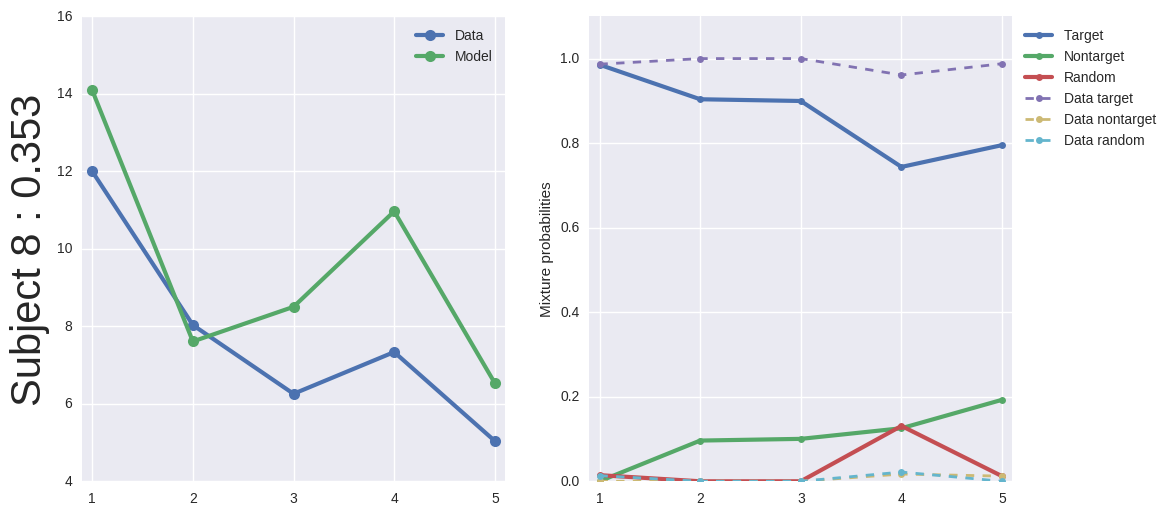

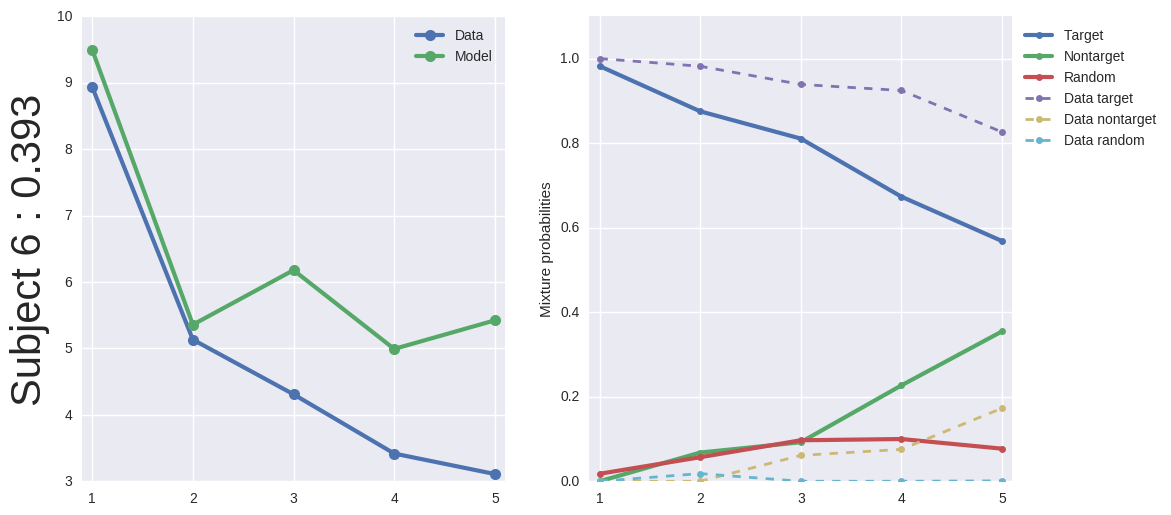

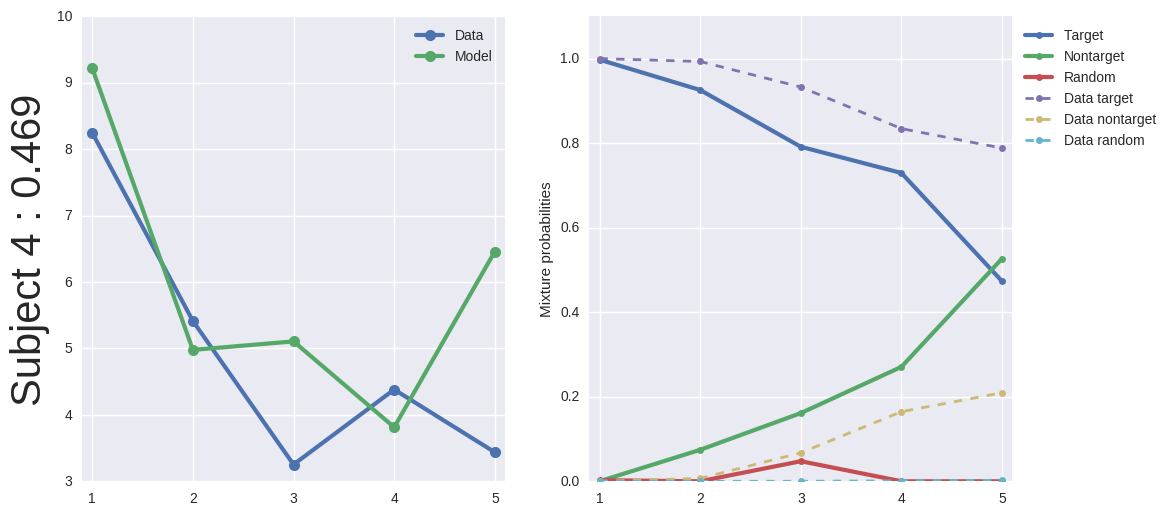

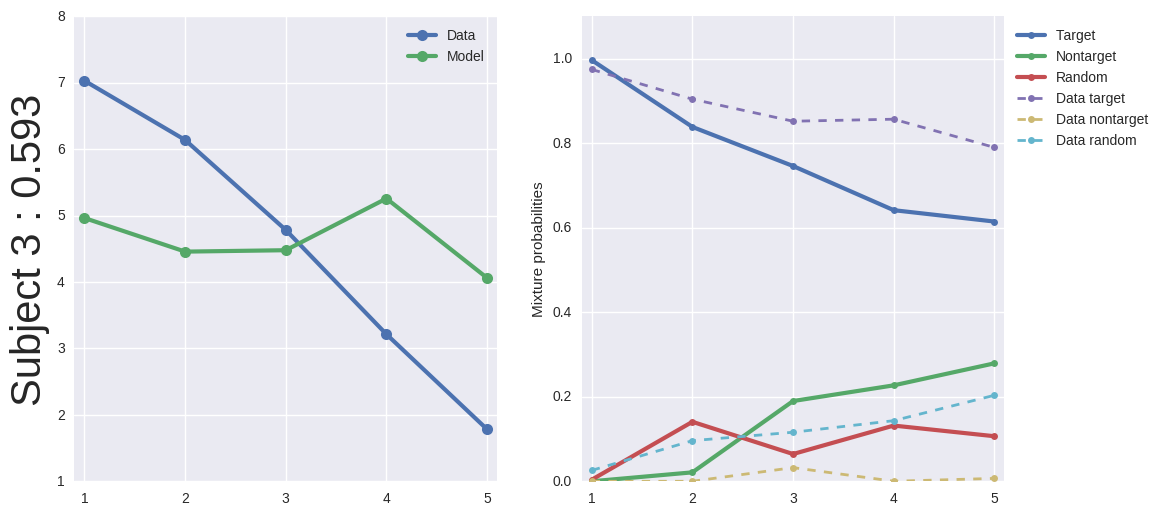

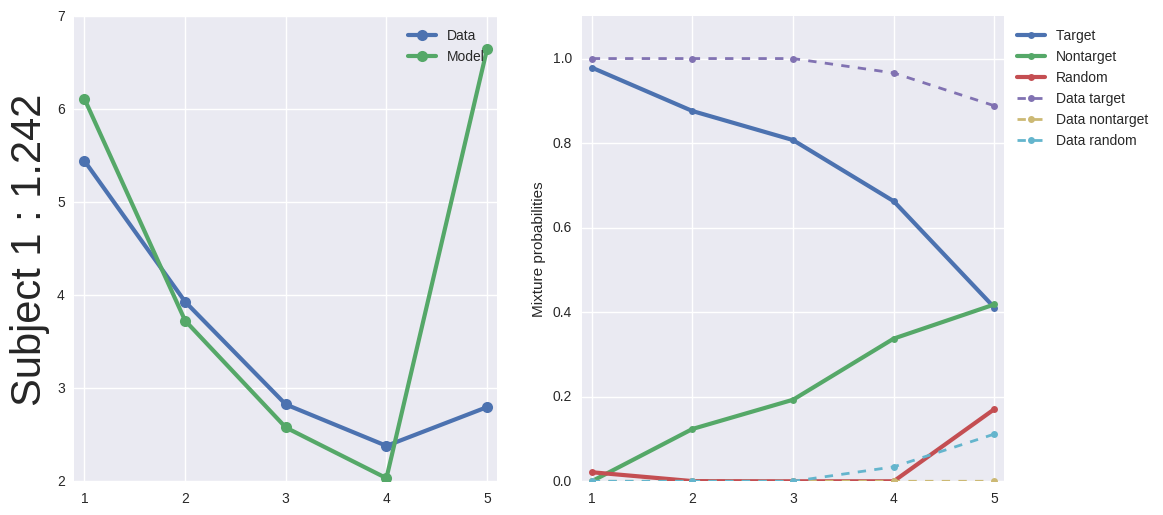

In [16]:
subj_fits_axes = dict()
with io.capture_output(display=False) as captured:
    for subject in subject_space_sorted_bis:
        subj_fits_axes[subject] = all_plots_fit_exp[subject].plots_memmixtcurves_fig6fig13(num_repetitions=1, 
                                                                        use_cache=True, 
                                                                        layout='horizontal')
        subj_fits_axes[subject][0].set_ylabel(
            'Subject %d : %.3f' % (subject, dist_emfitscaled_subjects[subject-1]), fontsize=30)
        subj_fits_axes[subject][0].set_title('')
        subj_fits_axes[subject][1].set_title('')
        subj_fits_axes[subject][0].set_xlabel('')
        subj_fits_axes[subject][1].set_xlabel('')

## Checking if average of parameters gives a good fit to the overall dataset

In [17]:
# Compute average parameter
df_avgparams_subjects = df_bestparams_subjects.median()
df_avgparams_subjects

step                       1588.500000
experiment_subject            4.500000
dist_emfit_scaled             0.211562
M                            66.500000
lapse_rate                    0.000756
ratio_conj                    0.820513
sigma_baseline                0.302165
sigmax                        0.071892
dist_emfit_scaled_log        -1.554954
dist_emfit_scaled_log10      -0.675308
dtype: float64

In [18]:
experiment_parameters = dict(action_to_do='launcher_do_fitexperiment_allmetrics',
                             inference_method='none',
                             experiment_id='gorgo11',
                             selection_method='last',
                             renormalize_sigma=None,
                             sigmay=0.00001,
                             num_samples=10,
                             code_type='mixed',
                             slice_width=0.07,
                             burn_samples=10,
                             ratio_conj=0.7,
                             stimuli_generation_recall='random',
                             autoset_parameters=None,
                             )

experiment_parameters.update(df_avgparams_subjects)
for key in ['M', 'experiment_subject']:
    experiment_parameters[key] = int(experiment_parameters[key])
    
with io.capture_output(display=False, stderr=True) as captured:
    experiment_launcher = ExperimentLauncher(run=True, arguments_dict=experiment_parameters)
    avgparam_fit_exp = experiment_launcher.all_vars['fit_exp']
    avgparam_results = experiment_launcher.all_vars['all_outputs_data']
    avgparam_plots_fit_exp = PlotsFitExperimentAllTPaperTheo(avgparam_fit_exp)


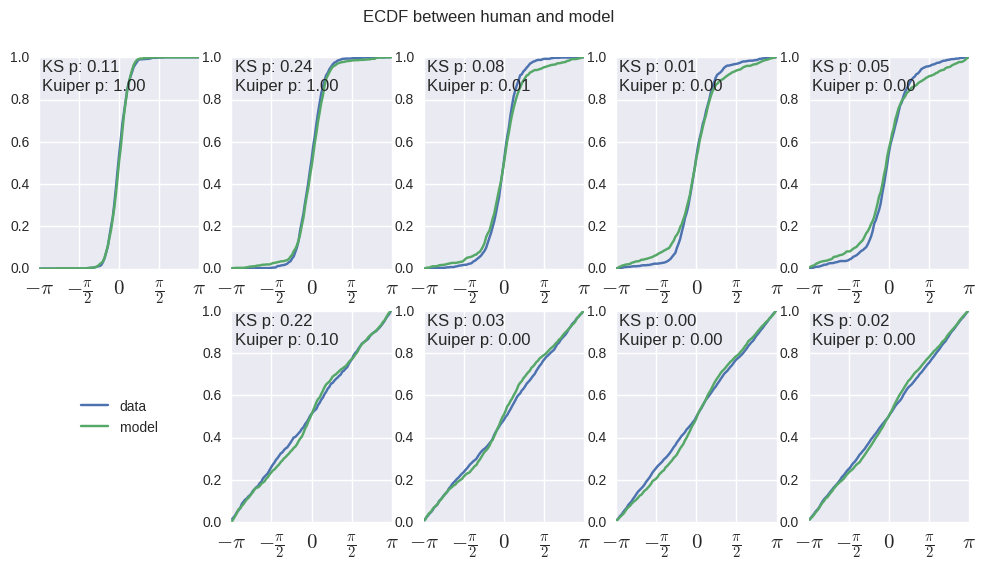

In [19]:
with io.capture_output(display=False) as captured:
    _ = avgparam_plots_fit_exp.plots_KS_comparison_fig2fig5(bins=100)

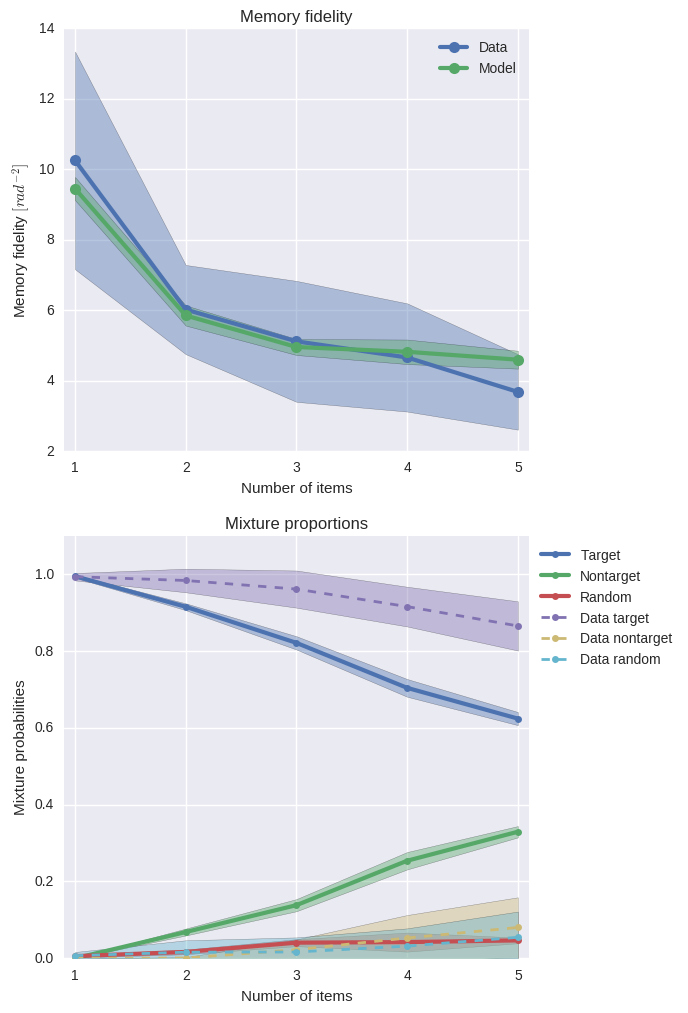

In [20]:
with io.capture_output(display=False) as captured:
    _ = avgparam_plots_fit_exp.plots_memmixtcurves_fig6fig13(num_repetitions=5, use_cache=True)

## Checking averaging the Subjects EM Fits

In [21]:
subjects_em_fits_list = []
for subject in subject_space:
    for T_i, T in enumerate(T_space):
        em_fits_subject = all_results[subject]['result_em_fits'].squeeze()
        subjects_em_fits_list.append(
            dict(subject=subject,
                 T=T,
                 em_kappa=em_fits_subject[T_i, 0],
                 em_target=em_fits_subject[T_i, 1],
                 em_nontarget=em_fits_subject[T_i, 2],
                 em_random=em_fits_subject[T_i, 3],
                 em_ll=em_fits_subject[T_i, 4],
                 em_bic=em_fits_subject[T_i, 5],
                 model_bic=all_results[subject]['result_bic'].squeeze()[T_i],
                 model_ll=all_results[subject]['result_ll_sum'].squeeze()[T_i]
                )
            )

subjects_em_fits_df = pd.DataFrame(subjects_em_fits_list)
subjects_em_fits_df

,T,em_bic,em_kappa,em_ll,em_nontarget,em_random,em_target,model_bic,model_ll,subject
0,1,146.348695,6.110989,-63.964007,0.000000,2.136911e-02,0.978631,294.899605,-138.239462,1
1,2,228.605234,3.727252,-105.092277,0.123703,4.249722e-04,0.875872,271.769576,-126.674447,1
2,3,290.209308,2.578363,-135.894313,0.192893,8.172520e-06,0.807098,303.256478,-142.417898,1
3,4,323.559332,2.033302,-152.569326,0.337499,2.333086e-05,0.662478,386.049827,-183.814573,1
4,5,319.581293,6.648453,-150.580306,0.418325,1.706304e-01,0.411044,380.249071,-180.914195,1
5,1,82.264961,10.751435,-31.922140,0.000000,1.262179e-02,0.987378,179.071087,-80.325203,2
6,2,132.501309,6.908198,-57.040314,0.018402,5.518789e-03,0.976079,316.370568,-148.974944,2
7,3,220.698904,7.794920,-101.139112,0.177069,8.343206e-02,0.739498,238.831811,-110.205565,2
8,4,187.071760,7.618215,-84.325540,0.166976,5.092936e-07,0.833024,291.795064,-136.687192,2
9,5,276.049473,5.349170,-128.814396,0.278536,6.649572e-02,0.654968,342.492466,-162.035893,2


In [22]:
# This computes the average fits across subjects. Exactly same as Fig 6!
subjects_pivot = subjects_em_fits_df[['em_kappa', 'em_target', 'em_nontarget', 'em_random', 'T']].groupby('T')

subjectsavg_emfit = dict(
    mean=subjects_pivot.mean().as_matrix(),
    std=subjects_pivot.std().as_matrix()
)

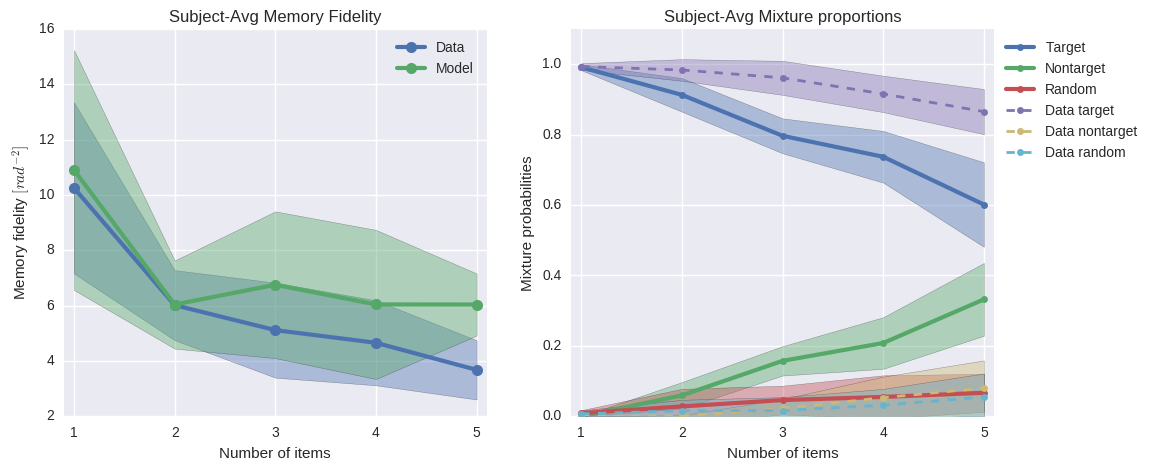

In [23]:
_, subj_avgfit = plt.subplots(1, 2, figsize=(12, 5))
avgparam_plots_fit_exp._PlotsFitExperimentAllTPaperTheo__plot_memcurves(subjectsavg_emfit, suptitle_text="Subject-Avg Memory Fidelity", ax=subj_avgfit[0])
avgparam_plots_fit_exp._PlotsFitExperimentAllTPaperTheo__plot_mixtcurves(subjectsavg_emfit, suptitle_text="Subject-Avg Mixture proportions", ax=subj_avgfit[1])

# ANALYSE ME



In [24]:
# Store figures
dataio = DataIO(output_folder=os.path.join(os.path.abspath("."), "outputs"), 
                label='thesis_subject_gorgo11_emfitscaled', calling_function='')
dataio.make_link_output_to_dropbox(dropbox_current_experiment_folder='fitexperiment_subject_cmaes_08_2016')

=== FileIO ready: /nfs/data3/lmatthey/visual_working_mem/fitexperiment_subject_cmaes_08_2016/5try_g11_emfit/outputs/thesis_subject_gorgo11_emfitscaled-d3942f51-fa73-4f34-ba08-d04602c02d59 ===
Doing dropbox symlink:  /nfs/data3/lmatthey/visual_working_mem/fitexperiment_subject_cmaes_08_2016/5try_g11_emfit/outputs /nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/code/git-bayesian-visual-working-memory/Experiments/fitexperiment_subject_cmaes_08_2016/fitexperiment_subject_cmaes_08_2016_5try_g11_emfit
Symlink failed:  /nfs/data3/lmatthey/visual_working_mem/fitexperiment_subject_cmaes_08_2016/5try_g11_emfit/outputs /nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/code/git-bayesian-visual-working-memory/Experiments/fitexperiment_subject_cmaes_08_2016/fitexperiment_subject_cmaes_08_2016_5try_g11_emfit


In [25]:
# Subject-Avg fits
subj_avgfit[0].figure.savefig(dataio.create_formatted_filename("subjectavg_{label}_{unique_id}.pdf"))

In [26]:
# Subjects fits
for subj, sub_axes in subj_fits_axes.iteritems():
    sub_axes[0].figure.savefig(dataio.create_formatted_filename("subject_%d_emfits_{label}_{unique_id}.pdf" % subj))

In [27]:
# Parameters
fig_parameters.savefig(dataio.create_formatted_filename("barplot_params_{label}_{unique_id}.pdf"))

In [28]:
# CDF
for subj, sub_axes in all_axes_cdf.iteritems():
    sub_axes[0, 0].figure.savefig(dataio.create_formatted_filename("cdf_subject_%d_{label}_{unique_id}.pdf" % subj), 
                                  bbox_inches='tight')